# Transformers (Attention is All You Need)

In [2]:
import math
from dataclasses import dataclass
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [14]:
@dataclass
class Config:
    d_model: int = 4
    n_heads: int = 1  # single head for clarity
    d_ff: int = 8
    vocab_size: int = 10
    max_len: int = 8
    num_layers: int = 1
    device: str = "cpu"
    lr: float = 0.02
    steps: int = 200  # adjust if you want it faster/slower
    seed: int = 0


cfg = Config()
torch.manual_seed(cfg.seed)


def causal_mask(seq_len):
    mask = torch.ones(seq_len, seq_len, dtype=torch.bool).tril()
    return mask.view(1, 1, seq_len, seq_len)

In [4]:
class SingleHeadSelfAttention(nn.Module):
    def __init__(self, d_model):
        super().__init__()
        self.W_q = nn.Linear(d_model, d_model, bias=False)
        self.W_k = nn.Linear(d_model, d_model, bias=False)
        self.W_v = nn.Linear(d_model, d_model, bias=False)
        self.W_o = nn.Linear(d_model, d_model, bias=False)
        self.last_attn = None  # store for visualization

    def forward(self, x, attn_mask=None, store_attn=False):
        B, T, D = x.shape
        Q = self.W_q(x)
        K = self.W_k(x)
        V = self.W_v(x)
        scores = (Q @ K.transpose(-2, -1)) / math.sqrt(D)  # [B,T,T]
        if attn_mask is not None:
            scores = scores.masked_fill(~attn_mask.squeeze(1), float("-inf"))
        attn = torch.softmax(scores, dim=-1)
        out = attn @ V
        out = self.W_o(out)
        if store_attn:
            self.last_attn = attn[0].detach().cpu()
        return out

In [5]:
class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff):
        super().__init__()
        self.fc1 = nn.Linear(d_model, d_ff)
        self.fc2 = nn.Linear(d_ff, d_model)

    def forward(self, x):
        return self.fc2(F.gelu(self.fc1(x)))

In [6]:
class TinyTransformerBlock(nn.Module):
    def __init__(self, d_model, d_ff):
        super().__init__()
        self.ln1 = nn.LayerNorm(d_model)
        self.sa = SingleHeadSelfAttention(d_model)
        self.ln2 = nn.LayerNorm(d_model)
        self.ffn = FeedForward(d_model, d_ff)

    def forward(self, x, attn_mask=None, store_attn=False):
        x = x + self.sa(self.ln1(x), attn_mask=attn_mask, store_attn=store_attn)
        x = x + self.ffn(self.ln2(x))
        return x

In [7]:
class TinyTransformer(nn.Module):
    def __init__(self, cfg: Config):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg.vocab_size, cfg.d_model)
        self.pos_emb = nn.Embedding(cfg.max_len, cfg.d_model)  # We are going to learn positional embedding
        self.blocks = nn.ModuleList([TinyTransformerBlock(cfg.d_model, cfg.d_ff) for _ in range(cfg.num_layers)])
        self.ln_f = nn.LayerNorm(cfg.d_model)
        self.head = nn.Linear(cfg.d_model, cfg.vocab_size)

    def forward(self, idx, store_attn=False):
        B, T = idx.shape
        pos = torch.arange(T, device=idx.device).unsqueeze(0).expand(B, T)
        x = self.tok_emb(idx) + self.pos_emb(pos)
        mask = causal_mask(T).to(idx.device)
        for i, block in enumerate(self.blocks):
            x = block(x, attn_mask=mask, store_attn=(store_attn and i == len(self.blocks) - 1))
        x = self.ln_f(x)
        return self.head(x)

    def last_attention(self):
        return self.blocks[-1].sa.last_attn

### Task

We are trying to learn to count:
* Given 0, we expect 1
* Given 1, we expect 2
* ...

In [11]:
# tiny next-token prediction sequences
base = torch.tensor([[0, 1, 2, 3, 4, 5], [1, 2, 3, 4, 5, 6]], dtype=torch.long)
targets = torch.tensor([[1, 2, 3, 4, 5, 6], [2, 3, 4, 5, 6, 7]], dtype=torch.long)

This is not a good task for a couple reasons:
* We do not have ambiguity in the next token
* We only really care about the previous word, not the entire sequence
  * Attention is not really needed! (We can see from the plot that we are basically looking at the last token)



In [15]:
# tiny next-token prediction sequences
base = torch.tensor([[0, 1, 2, 3, 4, 5], [1, 2, 3, 4, 5, 6]], dtype=torch.long)
targets = torch.tensor([[2, 3, 4, 5, 6, 8], [3, 4, 5, 6, 8, 9]], dtype=torch.long)

In [16]:
model = TinyTransformer(cfg).to(cfg.device)
opt = torch.optim.AdamW(model.parameters(), lr=cfg.lr)

# Training a Transformers is done just like any other Model
loss_history = []
for step in range(cfg.steps):
    logits = model(base, store_attn=(step == cfg.steps-1))
    loss = F.cross_entropy(logits.view(-1, cfg.vocab_size), targets.view(-1))
    opt.zero_grad(); loss.backward(); opt.step()
    loss_history.append(loss.item())

total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {total_params}") # Grows very fast
print(f"Final training loss: {loss_history[-1]:.4f}")

Total parameters: 286
Final training loss: 0.0045


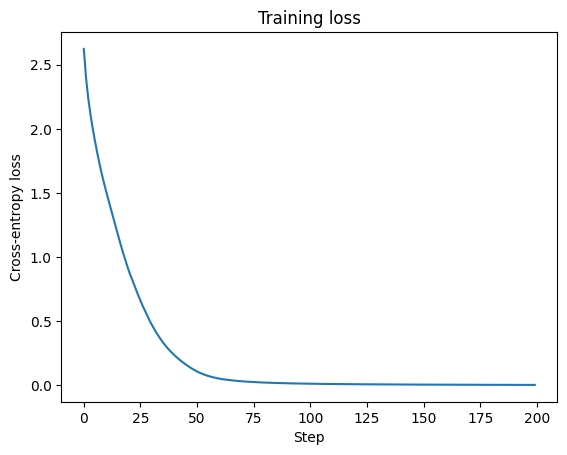

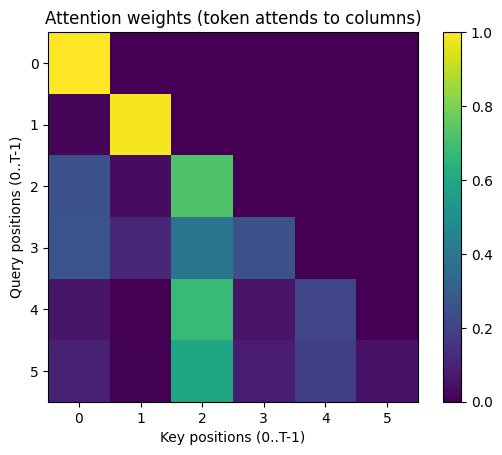

In [17]:
# 1) Loss curve
plt.figure()
plt.plot(loss_history)
plt.title("Training loss")
plt.xlabel("Step")
plt.ylabel("Cross-entropy loss")
plt.show()

# 2) Attention heatmap from last forward pass
attn = model.last_attention()
if attn is not None:
    plt.figure()
    plt.imshow(attn)
    plt.title("Attention weights (token attends to columns)")
    plt.xlabel("Key positions (0..T-1)")
    plt.ylabel("Query positions (0..T-1)")
    plt.colorbar()
    plt.show()
else:
    print("No stored attention to visualize.")